# Questrom School of Business - Graduate Certificate in Financial Technology
## Natural Language Processing - Deep Learning

In this notebook we go through some of the most used NLP algorithms.
We will first implement two very classic Machine Learning text classifier. In a second part we will create a word2vec embedding algorithm. We will use the results of our word2vec algorithm to extract certain sentences from our corpus of texts. Finally, the sentences extracted previously will be used to extract valuable information from the texts.

Author: Severin Boussie

<h3>Plan</h3>

<ol type="A">
  <li>Ml Classification</li>
  <li>The word2vec contextual vectorizer</li>
  <li>Sentence extraction for information concentration</li>
  <li>Information extraction using deep classifiers</li>
</ol>


# Setup

<h3>Data</h3>
We will work on 2 Corpuses (or set of texts). All the texts or publicly available texts dealing with mutual funds. More precisely, the text has been extracted from the prospectuses of Mutual funds.
<ul>
  <li><u>MutualFundSummary</u><br>
      This file contains around 500 fund summaries in text files. A summary is the part of the prospectus that summaries the objective of the fund, the principal strategy, the decomposition of the fees, the principal risks that face the fund and some other information about the management of the fund.
  </li>
  <li><u>MutualFundLabels.csv</u><br>
      This table contains information about around 400 mutual funds. We will mostly focus on the "derivative" column that states whereas funds use derivatives or not. (the precise schema of the table is given later)
  </li>
  <li><u>FundArticlesHealthy.csv</u><br>
      Set of News Articles dealing with funds that contains valuable information such as target of the fund, closure date of the fund, present value of the fund... </br>
In order to build this dataset, we extracted from various financial news website (such as financial time, finance-CNBC, Wall street journal...) a set of articles that deals with Funds. Then we selected from this corpus the articles that contained certain specific information. Such information included but is not limited to new managers, expected return, closure date, Equity investment per Found, Name of the parent company.
  </li>
  <li><u>FundArticlesUnhealthy.csv</u><br>
      In this table we have all the news articles dealing with funds that was extracted from news websites but that doesn't contain any useful information.
  </li>
</ul>


Let's first setup our environment.

I recommend you add a <b>GPU</b> to the colab virtual machine. <br>
Edit -> Notebook settings -> Hardware accelerator -> GPU -> SAVE


In [3]:
# Install tensorflow 2 to the virtual environment.
!pip install --upgrade tensorflow

# Restart Runtime after installation !
# -> Runtime -> Restart Runtime...
# Rerun the cell when the runtime has restarted

Requirement already up-to-date: tensorflow in /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages (2.1.0)
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
# Uncomment if you aare using colab. Now we connect the colab notebook to our drive to access the data.
# from google.colab import drive
# drive.mount('/content/gdrive')
# Run the cell and follow the instructions

In [1]:
# Import the libraries

import os
import sys
from IPython.display import HTML, display

import numpy as np
import pandas as pd
import tensorflow as tf
from math import ceil
from scipy.spatial.distance import cosine

import matplotlib.pyplot as plt
import seaborn as sns

import collections
import random
import time
import string
import re

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Embedding, Dense, Convolution1D, MaxPooling1D, GlobalMaxPooling1D, Flatten, Dropout, LSTM, Bidirectional

/Users/haoxing/.local/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/haoxing/.local/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/haoxing/.local/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/haoxing/.local/lib/python3.6/site-packages/tensorboard/co

In [3]:
# We now set the directory to access the data
def find(name, path):
    for root, dirs, files in os.walk(path):
        if name in files:
            return os.path.join(root, name)

# The folder with the data and this script should be saved in your drive.
script_name = 'CourseWork_v2.ipynb'
script_path = find(script_name, '/content/gdrive/My Drive')
DIRECTORY = '.'#os.path.dirname(script_path)
# DIRECTORY = '/content/gdrive/My Drive/'+'path of the folder that contains this script'
# If your Drive is too large and the "find" function takes to much time, you can set the directory manually :

#SUMMARY_PATH = os.path.join(DIRECTORY, "Data", "MutualFundSummary")
SUMMARY_PATH = '/Users/haoxing/Documents/Work/Teaching/Machine learning for Finance/Codes/NLP/NLP_app/MutualFundSummary'
SUMMARY_LABELS_PATH = '/Users/haoxing/Documents/Work/Teaching/Machine learning for Finance/Codes/NLP/NLP_app/MutualFundLabels.csv'

HEALTHY_ARTICLES_PATH = os.path.join(DIRECTORY, "Data", "FundArticlesHealthy.csv")
UNHEALTHY_ARTICLES_PATH = os.path.join(DIRECTORY, "Data", "FundArticlesUnhealthy.csv")

glove_word2vec = 'glove.6B.50d.txt'
our_word2vec = 'word2vec_perso.txt'

In [3]:
#os.listdir('/content/')

# Util
Some useful functions. <br>
You don’t really need to understand them, these are utilities functions.
 

In [66]:
# Progress bar
def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

# Save a word2vec dictionary.
def save_word2vec(filename):
    with open(os.path.join('/Users/haoxing/Documents/Work/Teaching/Machine learning for Finance/Codes/NLP/NLP_app', filename),'a' , encoding='utf-8') as f :
        for k, v in word2vec.items():
            line = k+' '+str(list(v)).strip('[]').replace(',','')+'\n'
            f.write(line)

# Load a word2vec dictionary.
def load_word2vec(filename):
    word2vec = {}
    with open(os.path.join('/Users/haoxing/Documents/Work/Teaching/Machine learning for Finance/Codes/NLP/NLP_app', filename), encoding='utf8') as f:
        for line in f:
            try :
                values = line.split()
                word = values[0]
                vec = np.asarray(values[1:], dtype='float32')
                word2vec[word] = vec
            except :
                None
    return word2vec

# read the repo in PATH and append the texts in a list
def get_data(PATH):
    list_dir = os.listdir(PATH)
    texts = []
    fund_names = []
    out = display(progress(0, len(list_dir)-1), display_id=True)
    for ii, filename in enumerate(list_dir) :
        with open(PATH+'/'+filename, 'r', encoding="utf8") as f :
            txt = f.read()
            try :
                txt_split = txt.split('<head_breaker>')
                summary = txt_split[1].strip()
                fund_name = txt_split[0].strip()
            except :
                summary = txt
                fund_name = ''
        texts.append(summary)
        fund_names.append(fund_name)
        out.update(progress(ii, len(list_dir)-1))
    return fund_names, texts

# A- ML Classification for summary detection

<b>Objective</b><br>
Imagine you are a big financial corporation; you receive thousands of new articles about funds every day and you need to know what these articles says. The easy but expensive solution is to have a team that read all the articles and fill excels with the import information. The other solution is NLP!<br>
In the following section we will work on the first piece of a framework aimed at extracting information from an unstructured feed of news article. Before implementing the actual extraction, we need to structure the data. By going through the data, you observe that half of the articles you receive are irrelevant to your buisness and does not contain any valuable information. Your first objective is to filter out these documents. <br>
As NLP expert you have been asked to create a text classifier that would automaticaly classify the articles that contains valuable information (the healthy documents) to the articles that don't (the unhealthy articles). <br>
In this section we create two ML text classifiers aimed at classifying the healty documents to the unhealthy documents.



### 1_ Read and format Data

We load the two classes of documents: the healthy and the unhealthy documents.

In [5]:
#df_healthy = pd.read_csv(HEALTHY_ARTICLES_PATH).sample(1000) # We reduce the size of the corpus to speed up the training
df_healthy = pd.read_csv('FundArticlesHealthy.csv').sample(1000)
healthy_articles = list(df_healthy['Healthy Fund Articles'].values)
#df_unhealthy = pd.read_csv(UNHEALTHY_ARTICLES_PATH).sample(1000)
df_unhealthy = pd.read_csv('FundArticlesUnhealthy.csv').sample(1000)
unhealthy_articles = list(df_unhealthy['Unhealthy Fund Articles'].values)

We create our corpus of text X and our target values y. The target of a summary is 1 and the target of a non-summary document is 0.

In [6]:
X = np.array(healthy_articles + unhealthy_articles)
y = np.concatenate((np.ones(len(healthy_articles)),np.zeros(len(unhealthy_articles))))

Split data in training and testing sets.<br>
30% of the data will be used to assess the performance of our classification. <br>
Setting random state allows to have the same split whenever we reload this cell. That way, we make sure to keep the test sample independent to the training.


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### 2_ Preprocess the texts

<b>How to prepare the texts for the classification ?</b><br>
The first step of any NLP framework is text pre-processing. It consists in preparing the text for the rest of the framework. For text classification problems, text normalization and removing stopwords are two pre-processing technics that ease the computer's understanding of the texts.  
<ul>
  <li>
      <u>Text normalization</u>
  </li>
For grammatical reasons, documents are going to use different forms of a word, such as organize, organizes, and organizing. Additionally, there are families of derivationally related words with similar meanings, such as democracy, democratic, and democratization. Keeping these words variations complexify the classification task and should be treated during the pre-processing.

The goal of text normalization is to reduce inflectional forms and sometimes derivationally related forms of a word to a common base form. For instance:

am, are, is $\Rightarrow$ be<br>
car, cars, car's, cars' $\Rightarrow$ car<br>

There are two main technics: Stemming and Lemmatization: <br>

Stemming usually refers to a crude heuristic process that chops off the ends of words in the hope of achieving this goal correctly most of the time, and often includes the removal of derivational affixes. 
Lemmatization usually refers to doing things properly with the use of a vocabulary and morphological analysis of words, normally aiming to remove inflectional endings only and to return the base or dictionary form of a word, which is known as the lemma.<br>

Unlike stemming, lemmatisation depends on correctly identifying the intended part of speech and meaning of a word in a sentence, as well as within the larger context surrounding that sentence, such as neighboring sentences or even an entire document.

For instance:

    1.The word "better" has "good" as its lemma. This link is missed by stemming, as it requires a dictionary look-up.
    
    2.The word "walk" is the base form for the word "walking", and hence this is matched in both stemming and lemmatisation.
    
    3.The word "meeting" can be either the base form of a noun or a form of a verb ("to meet") depending on the context; e.g., "in our last meeting" or "We are meeting again tomorrow". Unlike stemming, lemmatisation attempts to select the correct lemma depending on the context.
    
In our case, we will use the lemmmatizer provided by the nltk library.


  <li>
      <u>Stopwords</u>
  </li>
Stopwords are those words that do not provide any useful information to decide in which category a text should be classified. This may be either because they don't have any meaning (prepositions, conjunctions, etc.) or because they are too frequent in the classification context. We remove stopwords so that more focus can be given to those words which define the meaning of the text.
</ul>


In [8]:
def lemma_tokenizer(text):
    lemmatizer=WordNetLemmatizer()
    return [lemmatizer.lemmatize(token) for token in word_tokenize(text.replace("'"," "))]

In the preceding cell we create a function that lemmatize and tokenize the text.<br>Tokenization is the act of breaking up a sequence of strings into pieces such as words, keywords, phrases, symbols and other elements called tokens.<br>
The <u>lemma_tokenizer</u> function takes a string text as input and output the list of lemmatized words of this text.<br>
Then we create our list of stop words that we want to remove from the texts.

In [9]:
stop_words = set(stopwords.words("english")+list(string.punctuation)+['``',"''"]+["]","[","*"]+['doe', 'ha', 'wa'])

### 2_ Create word vectors

<b>How to vectorize texts?</b>
In order to feed the Machine Learning algorithms, we need to translate our texts in vectors. I present here the two most popular methods to perform text vectorisation.
<ul>
  <li>
      Bag of words (BoW for short)
  </li>
The bag of word model consists in counting the number of occurrence of words in the documents. If we call V the set of all the words present in our corpus of text, the BoW representation of document d is:

BoW(d) = [count(word, d) for word in V]

where count(word, d) is the number of occurrence of the word 'word' ind the document d.<br><br>
Let’s take an example to understand this concept in depth.
we consider the following corpus:<br>
“It was the best of times”<br>
“It was the worst of times”<br>
“It was the age of wisdom”<br>
“It was the age of foolishness”<br><br>
the vocabulary is: ‘It’, ‘was’, ‘the’, ‘best’, ‘of’, ‘times’, ‘worst’, ‘age’, ‘wisdom’, ‘foolishness’ <br><br>
The BoW representations are :<br>
“It was the best of times” = [1, 1, 1, 1, 1, 1, 0, 0, 0, 0]<br>
“It was the worst of times” = [1, 1, 1, 0, 1, 1, 1, 0, 0, 0]<br>
“It was the age of wisdom” = [1, 1, 1, 0, 1, 0, 0, 1, 1, 0]<br>
“It was the age of foolishness” = [1, 1, 1, 0, 1, 0, 0, 1, 0, 1]<br><br>
  <li>
      Tf-Idf
  </li>
TF-IDF stands for term frequency-inverse document frequency, this is an improvement of the bag of word model. Instead of simply counting the number of occurrences of each word, we compute a score that evaluates the importance of each words in the document:
$$
Tf-Idf(d)= [tf(word, d)*Idf(word, Corpus) for\ word\ in\ C]
$$<br><br>
tf(word,d) is the term frequency. This is a scoring of the frequency of the word in the current document.
$$
tf(word, d)=\frac{number\ of\ times\ w\ appears\ in\ d}{total\ number\ of\ words\ in\ d}
$$<br><br>
Idf(word, Corpus) is the inverse document frequency. This is a scoring of how rare the word is across documents.
$$
Idf(word, Corpus)=log(\frac{total\ number\ of\ documents\ in\ the\ Corpus}{number\ of\ documents\ with\ the\ word\ word\ in\ it})
$$<br><br> 
If we retake the previous example:
“It was the best of times” = [0.316, 0.316, 0.316, 0.607, 0.316, 0.478, 0, 0, 0, 0]<br>
“It was the worst of times” = [0.316, 0.316, 0.316, 0, 0.316, 0.478, 0.607, 0, 0, 0]<br>
“It was the age of wisdom” = [0.316, 0.316, 0.316, 0, 0.316, 0, 0, 0.478, 0.607, 0]<br>
“It was the age of foolishness” = [0.316, 0.316, 0.316, 0, 0.316, 0, 0, 0.478, 0, 0.607]<br><br>
We observe that the tfidf values for 'it', 'was', 'the', and 'of' are smaller than the tfidf values of the other words since these terms are common to all sentences. The intuition behind is that if a word occurs multiple times in a document, we should boost its relevance as it should be more meaningful than other words that appear fewer times (TF). At the same time, if a word occurs many times in a document but also along many other documents, maybe it is because this word is just a frequent word; not because it was relevant or meaningful (IDF). 
</ul>

<br><br>
<u>Important observation</u>: The dimension of the document's vectors is the total number of words in the vocabulary! Lemmatizing and removing the stop words allows to reduce the length of the vocabulary but this is still huge.  



In [10]:
max_features = 5000 # we will only consider the 5000 most frequent words to create the vectors. 
# This value is the size of the vocabulary that we use to vectorize.

In [11]:
# Create the vectorizer object that will create the vectors.
tfidf = TfidfVectorizer(input='content', tokenizer=lemma_tokenizer, stop_words=stop_words, max_features=max_features)
# The tfidf object use our lemma_tokenizer function and our stop_words list. It will clean the text while vectorizing it.

In [12]:
# Fits the tfidf vecotizer on the train sample and create the training features.
tfidf_train = tfidf.fit_transform(X_train)
# Uses the vectorizer to create the test features.
tfidf_test = tfidf.transform(X_test)

### 3_ First model : Multinomial naivebayes

The first machine learning algorithm we try is the multinomial naive Bayes model. You can read more about naive Bayes classifiers here: https://en.wikipedia.org/wiki/Naive_Bayes_classifier

We optimize the hyperparameters using a cross validation Grid search.

See MultinomialNB here:https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html

and also 

https://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes

In [13]:
# Set the parameteters
parameters = {'alpha': [1e-10, 1e-5, 1e-1, 0.5, 1, 2], 'fit_prior':[True, False]}

In [14]:
# Fit the grid search
NB = MultinomialNB()
classifierNB = GridSearchCV(NB, parameters, cv=2, iid=False)
grid = classifierNB.fit(tfidf_train, y_train)

In [15]:
# Get the results of the grid search
print()
means = classifierNB.cv_results_['mean_test_score']
stds = classifierNB.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, classifierNB.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
        % (mean, std * 2, params))
print()


0.803 (+/-0.017) for {'alpha': 1e-10, 'fit_prior': True}
0.803 (+/-0.017) for {'alpha': 1e-10, 'fit_prior': False}
0.831 (+/-0.029) for {'alpha': 1e-05, 'fit_prior': True}
0.831 (+/-0.030) for {'alpha': 1e-05, 'fit_prior': False}
0.843 (+/-0.017) for {'alpha': 0.1, 'fit_prior': True}
0.843 (+/-0.017) for {'alpha': 0.1, 'fit_prior': False}
0.844 (+/-0.011) for {'alpha': 0.5, 'fit_prior': True}
0.844 (+/-0.009) for {'alpha': 0.5, 'fit_prior': False}
0.847 (+/-0.017) for {'alpha': 1, 'fit_prior': True}
0.847 (+/-0.017) for {'alpha': 1, 'fit_prior': False}
0.851 (+/-0.019) for {'alpha': 2, 'fit_prior': True}
0.850 (+/-0.020) for {'alpha': 2, 'fit_prior': False}



In [16]:
# Prediction
y_pred_NB = classifierNB.predict(tfidf_test)

In [17]:
# Confusion Matrix
confusion_matrix(y_test, y_pred_NB)

array([[234,  64],
       [ 24, 278]])

In [18]:
# Performance Report
print(classification_report(y_test, y_pred_NB))

              precision    recall  f1-score   support

         0.0       0.91      0.79      0.84       298
         1.0       0.81      0.92      0.86       302

    accuracy                           0.85       600
   macro avg       0.86      0.85      0.85       600
weighted avg       0.86      0.85      0.85       600



The training is very fast and the results or pretty good. The multinomial Naive Bayes model is well suited for text classification and could be used as a reference for any text classification problem.

### 4_ Second model : Kernel SVM

The second model we will use is a Support Vector Classifier or SVC. You can read more about this model here: https://en.wikipedia.org/wiki/Support-vector_machine.<br>
Kernel SVM has proven to give very good results for text classification.

In [19]:
# Create the SVM classifier with sklearn
classifierSVC = SVC(C=1, kernel = 'rbf', gamma=0.85, probability=True)
# Fit on training set
classifierSVC.fit(tfidf_train, y_train)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.85, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

<u>Observation</u> : The main disadvantage of the SVM for text classification is that it could be very slow on large corpuses...<br> The hyper parameters of this model has been optimized using a cross validation grid search.


In [20]:
# Prediction
y_pred_SVC = classifierSVC.predict(tfidf_test)

In [21]:
# Confusion matrix
confusion_matrix(y_test, y_pred_SVC)

array([[259,  39],
       [ 34, 268]])

In [22]:
# Performance Report
print(classification_report(y_test, y_pred_SVC))

              precision    recall  f1-score   support

         0.0       0.88      0.87      0.88       298
         1.0       0.87      0.89      0.88       302

    accuracy                           0.88       600
   macro avg       0.88      0.88      0.88       600
weighted avg       0.88      0.88      0.88       600



### 5_ Use Cases

This kind of ML text classifiers are widely used in industry. I put here some very classical use cases.

* From a stream of various kind of documents multi class text classifiers can structure the data stream by separating the different kinds of documents.
* Binary text classifiers could be used in fraud detection to detect false information.
* It can be used to automate Customer relationship management (CRM)  tasks. 
* It can also be used to extract certain portions of large documents (extract summaries from prospectuses for instance).


text classifiers are highly customizable and has applications in all industries.
other applications are presented here: https://dzone.com/articles/text-classification-applications-and-use-cases


# B- Word2vec a contextual vectoryzer

<b>Objective</b><br>
In this section we will look at a second way to translate natural language to mathematical representations. We will more specifically work on word embedding: How to create a meaningful vectoral representation of words. We will implement a vanilla Word2vec algorithm that we will use throughout the rest of the notebook.


### 1_ Understand Context vectorisation

The word2vec skip-gram model is a deep learning model that allows to create for each word of a given set of documents a unique vector. These vectors are built such that two words that are used in the same context (context is defined here as the 3 to 5 words before and the 3 to 5 words after) are close in term of spatial distance.

<b>What is the idea Behind word2vec ?</b><br>
<ol>
    <li>
        Take a 3 layers neural network. (1 input layer + 1 hidden layer + 1 output layer).
    </li>
    <li>
        Feed it a word and train it to predict its neighbouring word.
    </li>
    <li>
        Remove the last (output layer) and keep the input and hidden layer.
    </li>
    <li>
        Now, input a word from the vocabulary. The output given at the hidden layer is the ‘word embedding’ of the input word.
    </li>
</ol>


That’s it! Just doing this simple task enables our network to learn interesting representations of words.

<b>What does that mean in practice?</b><br>
The deep learning model that we will use to create the word representation has the following structure:


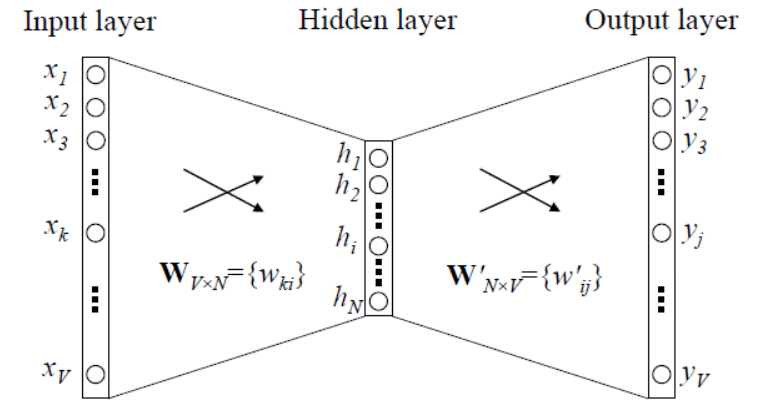

$$
h=W*x+b
$$
$$
y=softmax(W'*h+b')
$$
let f be the function of the total transformation:
$$
f(x)=softmax(W'*(W*x+b)+b')
$$<br><br>
Training the model means finding the parameters W, b, W' and b' that minimize a loss function between f(x) and the targeted value of y for x.


The inputs and outputs will be words in their "one-hot" representation form. (If each word of our vocabulary has a unique index, the one-hot representation of a word is the vector of size the size of the vocabulary and that have only zeros and 1 at the index of the word).

<u>How do we train the model? </u><br>
let’s C be our total corpus on which we will train our model. let’s n be the size of the corpus.
$$
C="w_1 w_2 ...w_{t}...w_{n-1} w_{n}"
$$<br><br>
We define the "local context" of a word in our corpus as the set of words inside a "window" around this word. For instance, if we take a window size of 3, the local context of the word in position t in our corpus is:
$$
c_3(w_t)=[w_{t-3},w_{t-2},w_{t-1},w_{t+1},w_{t+2},w_{t+3}]
$$<br><br>
We also define vocabulary of the corpus as the set of the V unique words found in the corpus.
$$
Vocabulary=set(C)=[u_1,...u_V]
$$<br><br>
the word u in the vocabulary appears several times in the corpus. We note o<font size="1">t</font> the set of indexes of the occurrences of u<font size="1">t</font> in the corpus
$$
o_t= {i|w_i=u_t}
$$<br><br>
Finally the "general context" of a word u<font size="1">t</font> in the vocabulary can be understood as the most frequent words in the union of the local contexts of the several representations of u<font size="1">t</font> ({c<font size="1">3</font>(w<font size="1">i</font>)|i in o<font size="1">t</font>}) in the corpus C. <br><br>
In the so called word2vec <b>skip-gram model</b>, for a given word u in the vocabulary, we want our model to learn a general context of u.
To do so we will input in our model every word in our corpus and force it to output the local context of these words. In other words our independent variables {x<font size="1">t</font>} are the one-hot representation of the words {w<font size="1">t</font>} in C and the dependant variables {y<font size="1">t</font>} are the one hot representation of words in their context {c<font size="1">5</font>(w<font size="1">t</font>)<font size="1">i</font>}. The training will minimize the distance (cross entropy) between y and f(x) so that f transform a word u in the vocabulary to a word likely to be in the context of u.


<u>How do we create our training sample? How do we build our input, output pairs ?</u> <br> First we should set a window size that defines the local context.<br> Then we can create our training samples by going through our corpus as shown in the following illustration :

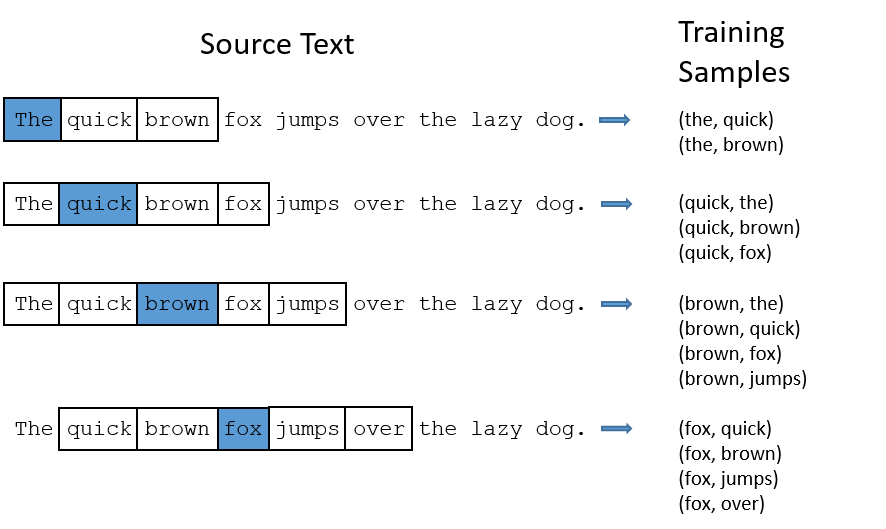

Ones we have our input, output word pairs we train the neural network with their one-hot representation (x, y). <br>
Through the training, the hidden layer could be interpreted as a representation of the "general context". Therefore for each words u in our vocabulary, h=W*onehot(u)+b is a unique N-dimensional vector representation of u that reflect the general context of u.

<b>How should the resulting vectors be interpreted?</b><br>
Ones the model is trained only the first part of the model interests us. The matrix W and the bias b allows us to translate the one-hot representation of a word in our corpus into is contextual representation. This representation could be interpreted as a spatial representation of the words in N dimensions such that the vectors of two words that are likely to appear in the same context are close in term of spatial distances.


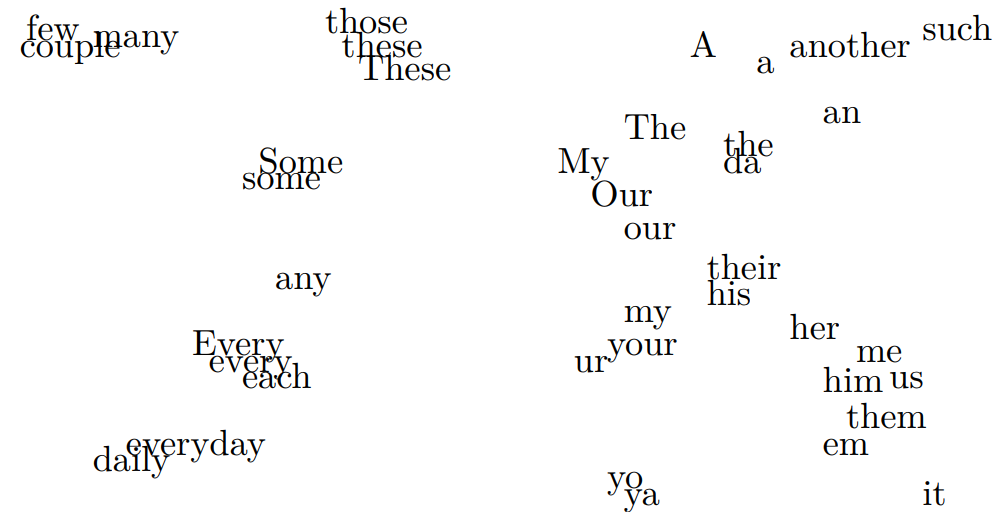

This representation is very useful because it allows to give a mathematical representation of words. For instance, this representation allows us to define mathematical distances between words. Moreover, we can now define sentences or texts as series of vectors that contains much more information than a tf-idf vectorisation. <br>
You will see throughout the rest of the notebook different use cases of this word vectorisation.


### 2_ Read and format the data

We will train the word2vec skip-gram model on the summaries. <br>
First, we create a Tokenizer function that cleans and tokenize the summaries. The main difference with the pre-processing of the previous part is that we don't want to lemmatize the documents. All the different words of our corpus (except the stopwords and the special characters) will have its own vector. <br>



In [23]:
# Get the summaries
fund_names, summaries = get_data(SUMMARY_PATH)
# The reading function can take several minutes depending on your internet connection.
# The reading function store the data in the cache so that rerunning the cell should be must faster.

The following tokenizer function takes a text as input. The function removes the stopwords, the tokens with no letters and returns a list of the remining tokens.

In [24]:
# clean and tokenize the text -> we don't want to lemmatize
def tokenizer(txt):
    txt = txt.replace('\n', ' ').replace('\t', ' ').lower()
    word_tokens = word_tokenize(txt)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    filtered_sentence = [w for w in filtered_sentence if re.sub("[^A-Za-z ]+",'',w) != ''] 
    return filtered_sentence

More cleaning could be done. We could for instance remove the tokens that have less than 3 letters or all the tokens that contains non-letter characters. <br>
Then we create one long list of tokens by tokenizing all the summaries with our "tokenizer" function and concatenating all the summaries.


In [25]:
text_words = np.concatenate([tokenizer(summary) for summary in summaries])

In [26]:
print(text_words[:20])

['investment' 'objective' 'thrivent' 'partner' 'healthcare' 'portfolio'
 'portfolio' 'seeks' 'long-term' 'capital' 'growth' 'fees' 'expenses'
 'table' 'describes' 'fees' 'expenses' 'may' 'pay' 'buy']


### 3_ Process Skip-Gram model Input

In [27]:
# Training Parameters
batch_size = 128 # The model will be trained batch per batch and one batch contains 128 rows
num_epochs = 2 # The model will go through all the data twice

* We set the dimension of our word vectors to 50. This is the embedding size and therefore the size of our hidden layer.
* We only consider the 5000 most frequent words.
* we set the window size to 3.
* Here we will only take 4 (num_skips) randomly chosen words in the local context of each word to build the input. (instead of all the local context as shown in the above example).


In [28]:
# Word2Vec Parameters
embedding_size = 50 # Dimension of the embedding vector
max_vocabulary_size = 5000 # Total number of different words in the vocabulary
min_occurrence = 10 # Remove all words that does not appears at least n times
skip_window = 3 # How many words to consider left and right
num_skips = 4 # How many times to reuse an input to generate a label

We start by building a dictionary that contains our vocabulary and the number of occurrences of each words : <u>count</u>

In [29]:
# Build the dictionary and replace rare words with UNK token
count = [('UNK', -1)]
# Retrieve the most common words
count.extend(collections.Counter(text_words).most_common(max_vocabulary_size - 1))
# Remove samples with less than 'min_occurrence' occurrences
for i in range(len(count) - 1, -1, -1):
    if count[i][1] < min_occurrence:
        count.pop(i)
    else:
        # The collection is ordered, so stop when 'min_occurrence' is reached
        break

Then, we give a unique id to each words in our vocabulary.

In [30]:
word2id = dict()
for i, (word, _)in enumerate(count):
    word2id[word] = i
id2word = dict(zip(word2id.values(), word2id.keys()))
vocab_size = len(id2word)

In [31]:
print ('size of the vocabulary : '+str(vocab_size))

size of the vocabulary : 3458


The length of the vocabulary corresponds to the 5000 most common words of our corpus minus the stop words. <br>
Then we create <u>data</u> which is simply the full tokenized corpus (text_words) where we filter out the words that are not in our vocabulary and we replace the actual words by their id.


In [32]:
# create data
data = list()
unk_count = 0
for word in text_words:
    # Retrieve a word id, or assign it index 0 ('UNK') if not in dictionary
    index = word2id.get(word, 0)
    if index == 0:
        unk_count += 1
    data.append(index)
count[0] = ('UNK', unk_count)

In [33]:
print(data[:20])

[3, 123, 3355, 498, 1844, 7, 7, 231, 281, 73, 91, 12, 9, 49, 338, 12, 9, 2, 66, 184]


We create a function that translate a word index to its one-hot representation (vector of zero with 1 in the word id position)

In [34]:
# build OneHot vector from index
def to_one_hot(data_point_index, vocab_size):
    temp = np.zeros(vocab_size)
    temp[data_point_index] = 1
    return temp

We are now ready to create the input of our model. <br>
The function <u>batch_generator</u> creates batches of 128 training rows that will be fed to our model. <br>
One raw is a couple (input, output) of one-hot word representations. An input vector is the one-hot representation of a word in our corpus and the associated output is the on-hot representation of one word in the local context of the input. <br>
The <u>batch_generator</u> function goes through our corpus (more precisely through <u>data</u>) and for each word, takes 4 (num_skips) words in its local context to create 4 rows. <br>
Ones 128 rows has been created (After 32 words), the function output a batch of these 128 rows and continue through the corpus. <br>
When all the corpus has been treated the function stops, we fed one epoch to the model.


In [35]:
# Generate training batch for the skip-gram model
def batch_generator(batch_size, num_skips, skip_window, vocab_size):
    data_index = 0
    while True :
        assert batch_size % num_skips == 0
        assert num_skips <= 2 * skip_window
        # batch is filled with 128 inputs
        batch = np.ndarray(shape=(batch_size), dtype=np.int32)
        # labels is filled with 128 outputs 
        labels = np.ndarray(shape=(batch_size), dtype=np.int32)
        span = 2 * skip_window + 1
        # buffer keep track of the visited indexes visited
        buffer = collections.deque(maxlen=span)
        if data_index + span > len(data):
            data_index = 0
            # We stop the loop when we went through all the corpus
            break
        buffer.extend(data[data_index:data_index + span])
        data_index += span
        for i in range(batch_size // num_skips):  
            # Take the context current word
            context_words = [w for w in range(span) if w != skip_window]
            # Randomly select num_skips words in the context
            words_to_use = random.sample(context_words, num_skips)
            for j, context_word in enumerate(words_to_use):
                # Creates one raw data
                batch[i * num_skips + j] = buffer[skip_window]
                labels[i * num_skips + j] = buffer[context_word]
            if data_index == len(data):
                buffer.extend(data[0:span])
                data_index = span
            else:
                buffer.append(data[data_index])
                data_index += 1
        # Backtrack a little bit to avoid skipping words in the end of a batch
        data_index = (data_index + len(data) - span) % len(data)

        # translate word index to on-hot representation
        batch_one_hot = np.array([to_one_hot(b, vocab_size) for b in batch])
        labels_one_hot = np.array([to_one_hot(l, vocab_size) for l in labels])

        # output one batch
        yield batch_one_hot, labels_one_hot

### 4_ Train the skip-gram model
We are ready to create and train the model.

In [36]:
# Create en compile the Autoencoder
def creat_word2vec_model():
    input_word = Input(shape=(vocab_size,))

    encoded = Dense(embedding_size, activation='linear')(input_word)
    decoded = Dense(vocab_size, activation='softmax')(encoded)

    # The autoencoder is the whole model with hidden layer contected to the output layer.
    autoencoder = Model(input_word, decoded)
    # The encoder is just the input layer connected to the hidden layer. One the Autoencoder will be trained we will use
    # the encoder to create our word vectors 
    encoder = Model(input_word, encoded)
    
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    return encoder, autoencoder

In [37]:
# We create the model
encoder, autoencoder = creat_word2vec_model()

In [38]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3458)]            0         
_________________________________________________________________
dense (Dense)                (None, 50)                172950    
_________________________________________________________________
dense_1 (Dense)              (None, 3458)              176358    
Total params: 349,308
Trainable params: 349,308
Non-trainable params: 0
_________________________________________________________________


In [39]:
# Finally we can train the model by feeding it with our batch generator !
autoencoder.fit_generator(batch_generator(batch_size, num_skips, skip_window, vocab_size), steps_per_epoch=ceil(len(data) / batch_size), epochs=num_epochs)

/opt/miniconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/2
7481/7481 [==============================] - 152s 20ms/step - loss: 0.0540
Epoch 2/2
7481/7481 [==============================] - 147s 20ms/step - loss: 0.0022


<h3>5_ Use the encoder to vectorize</h3><br>
The autoencoder has been trained, we can now use the matrix and bias of the encoder (input + hidden layer) to build our word representations !

In [40]:
# Create the Vectorizer function (prediciton of the encoder)
def vecotrize(word):
    word_one_hot = to_one_hot(word2id[word], vocab_size)
    return encoder.predict(np.array([word_one_hot]))[0]

In [41]:
# Create the word2vec dictionary
word2vec = {w : vecotrize(w) for w in word2id.keys()}

# This dictionary gives for all words it's vectorial representation.

In [44]:
# We can save the word2vec dictionary to reuse it later.
save_word2vec(our_word2vec)

<h3>6_Visualization</h3><br>
Now that we created our map, we can visualize the words!
We want to observe that words in the same context are spatially close.


<h5>a_ find the closer words</h5>

In [45]:
# for a given word, output the n closer words in the word2vec maping.
def get_n_closer(w, n, word2vec):
    vect = word2vec[w]
    distances_dict = {k: cosine(v, vect) for k, v in word2vec.items()}
    
    closer_words = []
    for _ in range(n):
        min_key = min(distances_dict.keys(), key=lambda k: distances_dict[k])
        closer_words.append(min_key)
        del distances_dict[min_key]
    return closer_words

In [47]:
words_neighbors_1 = get_n_closer('expenses', 10, word2vec)
print('words close to expenses : ' +str(', '.join(words_neighbors_1)))
words_neighbors_2 = get_n_closer('derivatives', 10, word2vec)
print('words close to derivatives : ' +str(', '.join(words_neighbors_2)))

words close to expenses : expenses, operating, annual, total, fees, table, reflected, fee, describes, acquired
words close to derivatives : derivatives, addition, significant, difficult, exposure, could, involve, loss, stocks, derivative



It makes sense!!! We clearly see here that the words have not been lemmatized, but we also see that words that has the same lemma (such that expenses and expense or derivatives and derivative) are very close in our word space. <br> 
The distances between words and their plurals in the word space might capture the idea of plurals. Lemmatizing the texts before training the word2vec model would have this eliminate this nuance and make our mapping poorer. <br>



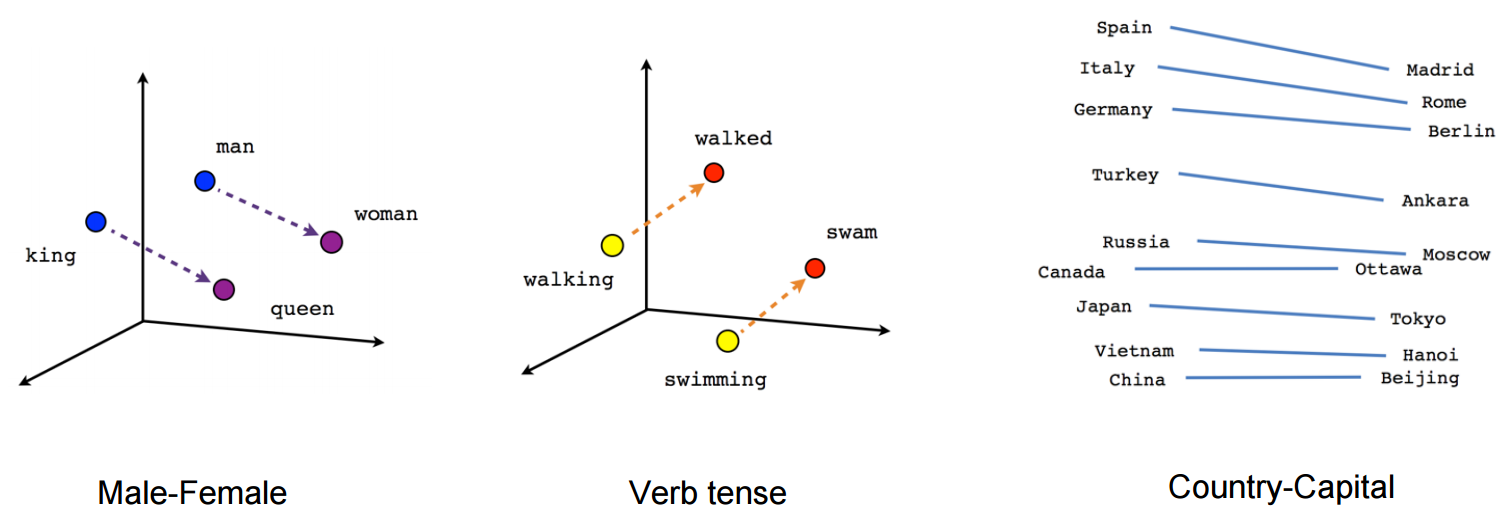

<h5>b_ plot closer words</h5>

We will use a TSNE model to reduce the word vectors to 2 dimensions. To learn more about the TSNE dimension reduction model I invite you to visit this link : https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding!

In [48]:
# fit the TSNE dimenstion reduction model
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
vectors = np.array([v for k, v in word2vec.items()])
words = np.array([k for k, v in word2vec.items()])
print(vectors.shape)

tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
vectors = tsne_model.fit_transform(vectors)

print(vectors.shape)

(3458, 50)
(3458, 2)


In [49]:
reduced_word2vec = {words[i] : list(vectors[i]) for i in range (len(vectors))}

In [50]:
def create_neighbors_visualisation_data(words, num_neighbors, word2vec):
    words_neighbors = []
    for word in words :
        try :
            words_neighbors.append(get_n_closer(word, num_neighbors, word2vec))
        except :
            print(word +' not in word2vec')

    words_neighbors = np.concatenate(words_neighbors)
    vectors_neighbors = np.array([reduced_word2vec[word] for word in words_neighbors])
    
    return vectors_neighbors[:,0], vectors_neighbors[:,0], words_neighbors
x, y, labels = create_neighbors_visualisation_data(['fee', 'swaps'], 10, word2vec)

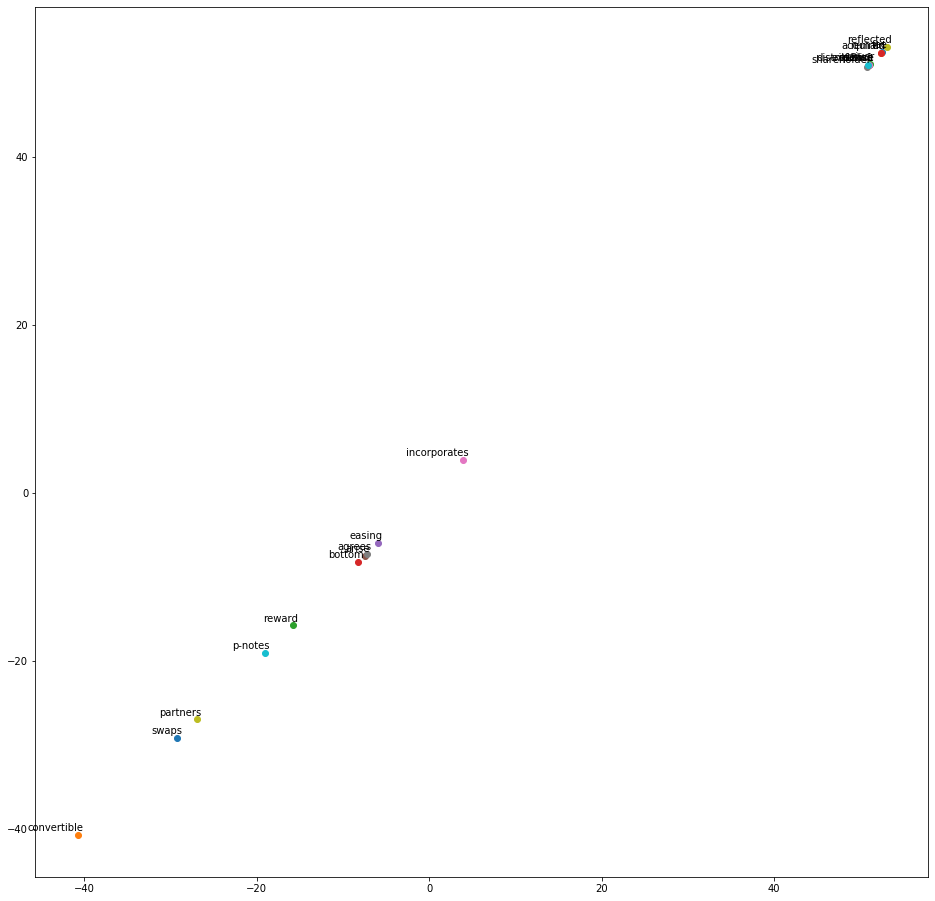

In [51]:
plt.figure(figsize=(16, 16)) 
for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(labels[i],
        xy=(x[i], y[i]),
        xytext=(5, 2),
        textcoords='offset points',
        ha='right',
        va='bottom')
plt.show()

We observe that these two set of words are really distant from one another! This is logic seems we took the small neighbourhood of different words. <br>
I invite you to use the above functions to plot different set of words and see how the contexts are represented.  


<h3>6_Some additional remarks</h3><br>
1_ the CBOW model is another word2vec similar to the skip gram model presented above to. Instead of having a word as input and its context as output of the autoencoder, the CBOW model take the context as input and tries to predict the word.

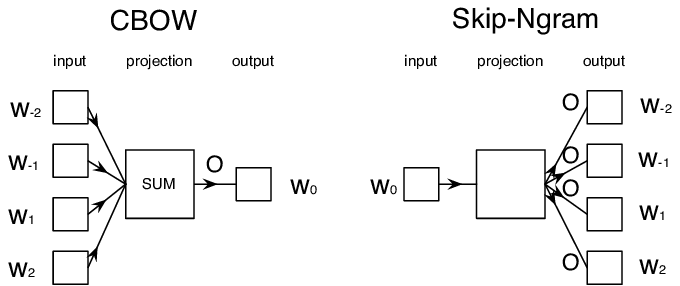

2_ There are more recent and more efficient ways to preform word2vec. Among these methods, the NSE have been developed to fasten the learning of words representation. You will find a good explanation of the NSE loss function in the following link:https://datascience.stackexchange.com/questions/13216/intuitive-explanation-of-noise-contrastive-estimation-nce-loss

3_ Standford CoreNLP is an integrated NLP toolkit that provides (among lots of other tools) different pretrained word2vec word mappings. These pretrained word vectors has been trained on very large corpus (Wikipedia 2014 and Gigaword 5) and are available in different dimensions. (https://nlp.stanford.edu/projects/glove/)<br>
The glove.6B.50d word mapping is in the data folder and we will use it later in this notebook.


# C- Sentence extraction

<h3>Objective</h3>
Our objective for the next two parts is to create a model that will be able to predict if a fund uses derivatives based on the summary.
The first step is to extract from the summaries the sentences that deals with derivatives.


<h3> 1_ Create a knowledge base </h3>

<b>What is a knowledge base? </b><br>
A knowledge base is an explicitly formulated domain or word knowledge. In other words, in language models, a knowledge base is a semantic dataset which is informing the model part of the pipeline. A knowledge base provides the computer with this semantic context while it is analysing the input data. For instance, A Knowledge base might contain definitions of entities or the sentiment of particular words. Systems based on knowledge base are widely used in NLP, this paper (https://pdfs.semanticscholar.org/6d85/d867de2fdb8d2e094a429a48ff4749b05603.pdf) give a good overview of KB-NLP systems (knowledge-based system). <br>
In our case, we will create a very simple knowledge base that only describes one domain: Derivatives. This knowledge base will be a simple set of words related to derivatives. This set defines the Entity derivatives.


<b>Why do we want to create a knowledge base? </b><br>
The objective of this section is to extract sentences that deals with the use of derivatives in the fund summaries. Having a knowledge base that gives a broad definition of Derivatives will allows us to score each sentence accordingly to their distance to the Entity Derivatives. The sentences that are the closer to our knowledge base are more likely to discuss about derivatives and will therefore be extracted.


<b>How we create the knowledge base? </b><br>
To create the knowledge base, we will use the word2vec we trained above. We start from a list of related words and extend this list by adding the "num_neighbors" closer words (in terms of distance in our word2vec space) of each word of this list.


In [52]:
key_words = ['bond', 'cash', 'swap', 'swaps', 'derivative', 'derivatives', 'futures', 'options', 'put', 'call', 'loan', 'loans', 'synthetic', 'underlying']

In [53]:
# Creates the knwoledge base by taking the num_neighbors closes neighbors of each key_words in word2vec
def create_knowledge_base(num_neighbors, word2vec, key_words):
    knowledge_base = set()
    out = display(progress(0, len(key_words)-1), display_id=True)
    for ii, key_word in enumerate(key_words) :
        knowledge_base.add(key_word)
        neighbors = []
        try :
            neighbors = get_n_closer(key_word, num_neighbors, word2vec)
        except :
            print(key_word + ' not in word2vec')

        knowledge_base.update(neighbors)
        
        out.update(progress(ii, len(key_words)-1))
    return knowledge_base

In [54]:
#word2vec = load_word2vec(our_word2vec)
knowledge_base = create_knowledge_base(5, word2vec, key_words)


We can now take a look at our knowledge base



In [55]:
print(knowledge_base)

{'renewed', 'regulations', 'typically', 'swaps', 'convertible', 'currencies', 'certain', 'addition', 'significant', 'valuation', 'loan', 'frameworks', 'difficult', 'times', 'values', 'impossible', 'options', 'derivative', 'depends', 'specifically', 'sustained', 'afforded', 'lower-yielding', 'reward', 'loans', 'international', 'known', 'forwards', 'include', 'profit', 'fluctuations', 'exposure', 'log', 'investing', 'disciplined', 'swap', 'contracting', 'clients', 'primarily', 'could', 'characterization', 'reed', 'bottom', 'futures', 'limits', 'invests', 'short-', 'underlying', 'weekly', 'increase', 'commonly', 'put', 'lose', 'inversely', 'bond', 'experiencing', 'call', 'san', 'easing', 'cash', 'probability', 'synthetic', 'derivatives', 'actions'}


<u>Observations</u> :<br>
1_ Some words such as leverage or hedged has been added to the knowledge base and makes perfect sense! <br>
2_ Other words such as power or international seems to make less sense for us! It doesn't mean that these words are irrelevant, may be the model is seeing things that we don't!

### 2_ Scoring function

The objective here is to score each sentence accordingly to their distance to the knowledge base. In order to extract the sentences that deals with the use of derivatives from the summaries. <br>
There is an infinite way of doing this scoring (see entity linking paper). We will implement 2 scoring functions and compare the performance of the overall extraction framework.


In [56]:
# We create here the dataframe tha contains the summaries along with their labels
df_extraction = pd.DataFrame({'fund_name' : fund_names, 'summary':summaries})
df_label = pd.read_csv(SUMMARY_LABELS_PATH)
df = df_label.merge(df_extraction, on='fund_name', how='left').dropna()
df.head()

,id,fund_name,Performance fee?,Ivestment Strategy,Leverage?,Portfolio composition,Concentration,summary
0,0000051931-18-000151,American Funds College 2018 Fund,None,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,American Funds College 2018 Fund\n\nInvestment...
1,0000051931-18-000151,American Funds College 2021 Fund,None,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,American Funds College 2021 Fund\n\nInvestment...
2,0000051931-18-000151,American Funds College 2024 Fund,None,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,American Funds College 2024 Fund\n\nInvestment...
3,0000051931-18-000151,American Funds College 2027 Fund,None,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,American Funds College 2027 Fund\n\nInvestment...
4,0000051931-18-000151,American Funds College 2030 Fund,None,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,American Funds College 2030 Fund\n\nInvestment...


<u>Schema of the data</u> :
* <b>id</b> : is a unique id attached to a mutual fund (this is the id given by the SEC)
* <b>fund_name</b> : is the name of the mutual fund
* <b>summary</b> : is the summary of the mutual fund
* <b>Performance fee?</b> : Answer the question : Does the fund assess performance fees ?<br> ['None', 'Some performance Fees']
* <b>Investment Strategy</b> : What is the main strategy of the fund ? <br>['Balanced Fund (Low Risk)', 'Fixed Income Long Only (Low Risk)', 'Equity Long Only (Low Risk)', 'Commodities Fund (Low Risk)', 'Long Short Funds (High Risk)']
* <b>Leverage?</b> : Does the fund use Derivatives ? <br> ['Yes', 'No']
* <b>Portfolio composition</b> : What is the main assets traded ? <br> ['Investment grade securities', 'Listed Equities', 'Sub-investment grade securities or emerging markets']
* <b>Concentration</b> : Does the fund assess a Concentration risk? <br> ['Diversified', 'Concentrated by issuer / sector / jurisdiction']
<br><br>
In the rest of the notebook we will mostly focus on The Leverage Column.

<b>a_ Using distances</b><br>
A first method to extract the sentences dealing with derivaties could be to take the distance between the barycentre of the sentence and the words in the knwoldege base. We create the distance score by averaging the n_closer smaller distances.

We should not forget that some words (the ones with low frequencies) are not in our word2vec mapping so, if there are less than n_reject vectorisable vectors in the sentence, we drop the sentence.

Finally, we can choose the number of sentences we want to extract (num_sent).

In [57]:
# Takes a summary, the knowledge base and some hyper parameters and returns the "num_sent" sentences
# of the summary that are closer to the the knowledge base in term of spacial distances.
def extract_sentence_distance(summary, knowledge, n_closer, n_reject, num_sent):
    # Split the summary into sentences.
    sentences = sent_tokenize(summary)
    sentence_scores = []
    # Loop over the sentences.
    for j, sentence in enumerate(sentences):
        # we tokenize and clean the sentence
        tokens = tokenizer(sentence)

        sentence_barycentre = np.zeros(embedding_size)
        effective_len = 0
        # Compute the barycentre of the sentence
        for token in tokens :
            try :
                sentence_barycentre += np.array(word2vec[token])
                effective_len += 1
            except KeyError :
                pass
            except :
                raise
        
        # Reject sentences with less than n_reject words in our word2vec map
        if effective_len <= n_reject :
            sentence_scores.append(1)    

        else :
            sentence_barycentre = sentence_barycentre/effective_len
            # Compute the distance sentece_barycentre -> words in our knowledge base
            barycentre_distance = [cosine(sentence_barycentre, word2vec[key_word]) for key_word in knowledge]
            barycentre_distance.sort()
            # Create the score of the sentence by averaging the "n_closer" smallest distances
            score = np.mean(barycentre_distance[:n_closer])
            sentence_scores.append(score)
    # Select the "num_sent" sentences that have the smallest score (smallest distance score with the knowledge base)
    sentence_scores, sentences = zip(*sorted(zip(sentence_scores, sentences)))
    top_sentences = sentences[:num_sent]
    return ' '.join(top_sentences)

In [58]:
# It takes several minutes (5-10 minutes)
df['deriv_sentences_distance'] = df.apply(lambda x : extract_sentence_distance(x['summary'], knowledge_base, n_closer=10, n_reject=5, num_sent=5), axis=1)

We cannot really assess the performance of the extraction. We will however see how this extraction impact the performance of the final extraction in the next section.

<b>b_ Match extraction</b><br>
The second method is simply to count the number of words that are in the intersection of the knowledge base and the sentence.
This scoring function is highly dependent on the number of neighbours  chose to create the knowledge base.

In [59]:
def extract_sentence_match(summary, knowledge, num_sent):
    sentences = sent_tokenize(summary)
    sentence_scores = []
    for j, sentence in enumerate(sentences):
        set_tokens = set(tokenizer(sentence))

        # Find the number of common words between the knowledge base and the sentence
        inter_knwoledge = set_tokens.intersection(knowledge)

        sentence_scores.append(len(inter_knwoledge))

    sentence_scores, sentences = zip(*sorted(zip(sentence_scores, sentences)))
    top_sentences = sentences[len(sentences)-num_sent-1:]
    return ' '.join(top_sentences)

In [60]:
df['deriv_sentences_match'] = df.apply(lambda x : extract_sentence_match(x['summary'], knowledge_base, num_sent=5), axis=1)

<h3>3_ Conclusion and Use Cases</h3><br> 
This kind of unsupervised algorithms based on word distances, token match, knowledge base is used in lots of different NLP frameworks. I put bellow a list of interesting use cases.

* Entity linking: [http://aidanhogan.com/docs/entity-linking-link.pdf]
* Entity disambiguation : [https://industry.datascience.columbia.edu/sites/default/files/documents/files/Named%20Entity%20Disambiguation%20and%20Other%20Semantic%20Technologies%20at%20Bloomberg.pdf]
* unsupervised sentiment analysis: [https://www.mitpressjournals.org/doi/pdf/10.1162/COLI_a_00049]


# D_ Information extraction using deep classifiers

<b>Objective</b><br>
In this section we will use the sentences that we extracted in the previous section to train 2 deep learning models aimed at predicting if a mutual fund uses derivatives based on its summary.

<h3>1_ Format data</h3><br>
In this paragraph we will prepare the corpus, the dependent variable and split the data to a training set and a testing set. <br>
The independent variable (the corpus) is the list of the sentences extracted in the previous section for each fund.


In [61]:
X = df['deriv_sentences_match'].values
# X = df['deriv_sentences_distance'].values # uncomment to use the first sentence extraction method.
# Clean the texts
X = [' '.join(tokenizer(txt)) for txt in X]
X[0][:100]

'underlying fund counterparty derivative transaction including applicable underlying fund clearing br'

In [62]:
y = df['Leverage?'].values
y = np.array([1 if x=='Yes' else 0 for x in y])

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

<h3>2_ Data pre-processing</h3><br>
<b>How do we need to format the data to feed the deep learning algorithms? </b><br>
As mentioned earlier, the word2vec representation of words could be used to create a representation of the documents. This process of using the a pretrained algorithm to feed the input of another algorithm is called learning transfer. We transfer the learnings of the skip-gram model to the classification model. <br><br>
The deep learning models takes as input the sequence of vector's representation of the words in the document.


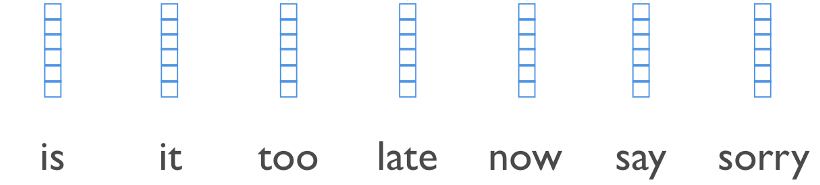

This input is much richer than the Bag of word or Tf-Idf document vectorization:
* We keep the information of the order of the words.
* Each word's vector contains a contextual information about the word
<br><br>
The dimension on the inputs should be the same so we will have to truncate the too long documents and complete the too short documents with null vectors. 

/opt/miniconda3/envs/tensorflow/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/miniconda3/envs/tensorflow/lib/python3.6/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


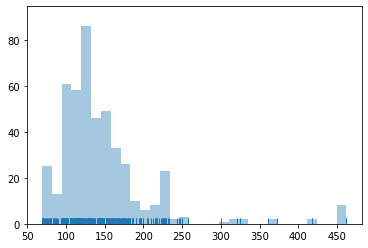

In [64]:
# In order to set the length of the document series (maxlen), we visualise the distribution of the number of words per documents.
sizes = []
out = display(progress(0, len(X)), display_id=True)
for ii, txt in enumerate(X):
    sizes.append(len(word_tokenize(txt)))
    out.update(progress(ii, len(X)))

sns.distplot(sizes, kde=False, rug=True)

First, we set the hyper parameters of the pre-processing phase.

In [65]:
num_words = 2500 # Size of the vocabulary used. we only consider the 2500 most common words. The other words are removed from the texts.
maxlen = 150 # Number of word considered for each document. we cut or lengthen the texts to have texts of 150 words.
word_dimension = 50 # dimension of our word vectors.

Then, we load the standford glove.6B.50d pretrained word2vec.

In [67]:
word2vec_g = load_word2vec(glove_word2vec)

We could also use our own word2vec to vectorize the words. Both word2vec has their advantages and disadvantages. <br>
I encourage you to test both vectorization and observe the impact on the performance of the classification. <br><br>
We start the feature creation by assigning a unique index to each word in the vocabulary of the corpus and transform the texts to a list of word index.


In [68]:
# The Tokenizer provided by the Keras library allows to perform such transformation.
keras_tokenizer = Tokenizer(num_words=num_words)
keras_tokenizer.fit_on_texts(X_train)
# word_index is the dictionary that contains the index of each words in our 2500 long vocabulary.
word_index = keras_tokenizer.word_index
sequences_train = keras_tokenizer.texts_to_sequences(X_train)
sequences_test = keras_tokenizer.texts_to_sequences(X_test)

In [69]:
print('Text : '+X_train[0])
print('Index sequences : ' +str(sequences_train[0]))

Text : minimum initial investment amounts share classes offered fund shown minimum initial investment class category eligible account accounts systematic investment plan accounts systematic investment plan accounts classes c accounts iras iras classes adv inst eligible accounts depending upon category eligible investor classes inst2 r eligible accounts none n/a class inst3 eligible accounts million depending upon category eligible investor certain eligible investors class shares must purchased financial intermediaries written agreement columbia management investment distributors inc. specifically authorized sell class shares value interests reit may affected among factors changes value underlying properties owned reit changes prospect earnings and/or cash flow growth reit defaults borrowers tenants market saturation decreases market rates rents economic political regulatory matters affecting real estate industry including reits include risks related general local economic conditions po

'Companies' has the index 41, 'may' 3 and so forth<br><br>

Then we use the pad_sequence function provided by keras to truncate or lengthen (by adding zeros) each text so they all have the same length : 150

In [70]:
feature_train = pad_sequences(sequences_train, maxlen=maxlen, dtype=float, padding='post', truncating='post')
feature_test = pad_sequences(sequences_test, maxlen=maxlen, dtype=float, padding='post', truncating='post')

In [71]:
print ('length of the first sequence : '+str(len(sequences_train[0])) )
print ('length of the paded first sequence : '+str(len(feature_train[0])) )

length of the first sequence : 228
length of the paded first sequence : 150


Finally, we create our embedding matrix. This is a (2500,50) array filled with the vector's representation of the words in our vocabulary. The line i is the vector representation of the word that has the index i.

In [72]:
embedding_matrix = np.zeros((len(word_index) + 1, word_dimension))
for word, i in word_index.items():
    embedding_vector = word2vec_g.get(word)
    #embedding_vector = word2vec.get(word)   # uncomment to use our own word2vec
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Now that each text has been translated to a 150 long vector of word indexes and that we have a matrix that transform a word index to its vector representation, we are ready to implement the deep learning models.

<h3>3_ First Model : One dimensional Convolutional Neural Network</h3>

Before jumping in to the implementation of the model, we should take a moment to understand how a Convolutional Neural Network (CNN) works and why is it well adapted for text classification.

<b>What is a 1 dimensional Convolutional Neural Network ?</b>

Convolutional Neural Networks has first been developed for computer visions problems. The main idea is to break down a given image to a set meaningful new images by applying different filters to this image. Please find bellow an example of 2 filters applied to the same image.

<u>Original Image</u> :

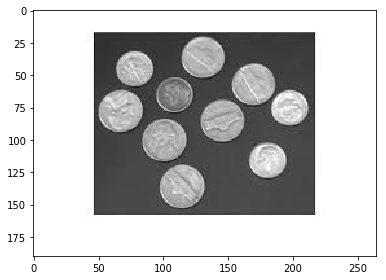

<u>Filtered Images</u> :

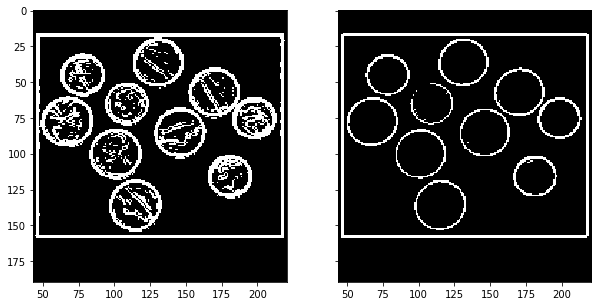

By applying different filters, we can highlight different local aspects of the picture. The training of a CNN classifier consists in optimizing these filters so that the outputted images highlight the best features to perform the classification. For more details on how we apply the filters, how the optimization system optimize the filters and how the outputted images are then used to perform the classification I invite you to read this paper : https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53

<b>For texts </b> the idea is the same: we train the model to optimize filters that goes through the documents and search for local patterns that best highlight the information we want to extract. For images, the patterns are highlighted by applying filters on the colour’s intensity nuances and for texts the filters are applied on the contextual vectors of the words in the sentences.

<b>Why are CNNs well adapted for text classification ?</b>

The same reasons that makes CNNs very efficient for image classification applies to text classification. 1-DCNNs extract features from local input patches allowing for representation modularity.1D convolution layers are also translation invariant in the sense that because the same input transformation is performed on every patch, a pattern learned at a certain position in a sentence can later be recognized at a different position. 

<b>a_ Training of the CNN</b>


In [73]:
def create_CNN_model():
    CNN = Sequential()
    # The Embedding layer takes the embedding matrix as an argument and transform the inputed the sequences of index to sequences of vectors.
    CNN.add(Embedding(len(word_index) + 1, word_dimension, weights=[embedding_matrix], input_length = maxlen, trainable=False))


    CNN.add(Convolution1D(64, 5, activation = 'relu'))
    CNN.add(MaxPooling1D(pool_size = 5))

    CNN.add(Convolution1D(32, 5, activation = 'relu'))
    CNN.add(MaxPooling1D(pool_size = 5))

    CNN.add(Flatten())
    CNN.add(Dense(units = 128 , activation = 'relu'))
    CNN.add(Dropout(0.5))
    CNN.add(Dense(units = 1, activation = 'sigmoid'))

    CNN.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return CNN

In [74]:
CNN_model = create_CNN_model()

In [75]:
CNN_history = CNN_model.fit(feature_train, y_train, epochs=10, batch_size=16, validation_data=(feature_test, y_test))

Epoch 1/10
24/24 [==============================] - 1s 34ms/step - loss: 0.7806 - accuracy: 0.4970 - val_loss: 0.5482 - val_accuracy: 0.7340
Epoch 2/10
24/24 [==============================] - 0s 10ms/step - loss: 0.5500 - accuracy: 0.7578 - val_loss: 0.5071 - val_accuracy: 0.7766
Epoch 3/10
24/24 [==============================] - 0s 10ms/step - loss: 0.4320 - accuracy: 0.7963 - val_loss: 0.3525 - val_accuracy: 0.8191
Epoch 4/10
24/24 [==============================] - 0s 9ms/step - loss: 0.2864 - accuracy: 0.9081 - val_loss: 0.3118 - val_accuracy: 0.8298
Epoch 5/10
24/24 [==============================] - 0s 10ms/step - loss: 0.2050 - accuracy: 0.9340 - val_loss: 0.2061 - val_accuracy: 0.9362
Epoch 6/10
24/24 [==============================] - 0s 10ms/step - loss: 0.1580 - accuracy: 0.9589 - val_loss: 0.1802 - val_accuracy: 0.9468
Epoch 7/10
24/24 [==============================] - 0s 9ms/step - loss: 0.0995 - accuracy: 0.9677 - val_loss: 0.1522 - val_accuracy: 0.9468
Epoch 8/10
24/2

Some visualizations of the training :

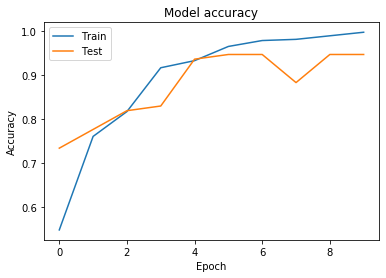

In [76]:
# Plot training & validation accuracy
plt.plot(CNN_history.history['accuracy'])
plt.plot(CNN_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

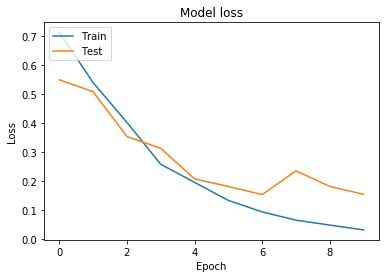

In [77]:
# Plot training & validation loss values
plt.plot(CNN_history.history['loss'])
plt.plot(CNN_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


<b>b_ Evalutation</b>



We can use the ROC curve to assess the performance of the classification. You can learn more about the ROC curve here :https://en.wikipedia.org/wiki/Receiver_operating_characteristic

In [78]:
y_pred_CNN = CNN_model.predict(feature_test)

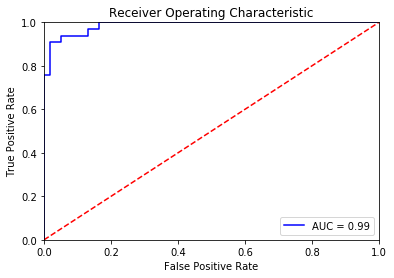

In [79]:
fpr, tpr, threshold =roc_curve(y_test, y_pred_CNN)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

<h3>4_ Second Model : Recurrent Neural Networks</h3>

Like for the CNN, lets first take a close look at how does a Recurrent Neural Network (RNN) works and why is this type of model actually well adapted to texts classification.

<b>What is a RNN and how does it work ?</b><br>
An RNN is a specific kind of neural network that have the following two properties:
* They make use of sequential information.
* They have a memory that captures what have been calculated so far.
<br><br>
For a given document, the RNN layer takes each word sequentially and at a given word, build a vector that combines the information of the current word with the information of all the preceding words. When the layer when through all the document, the output vector reflects the information of each words of the documents taken sequentially. 
<br>
The optimisation of this layer tends to find the best way to understand the sequence of words in order to answer the final question: is the fund using derivatives.
<br><br>
What does it mean mathematically ?
<br>
I our case the words have 50 dimensions and a document is composed of 150 words. Let’s xt be the t-th word of a given document. A document could be written as followed:
$$
[x_1,x_2\ ,...,x_{t-1},x_t,x_{t+1},...\ ,x_{250}\ ]
$$
for t going from 1 to 250, the RNN layer compute sequentially:
$$
h_t=f(W*x_t+U*h_{t-1}+b)
$$
Where f is a nonlinear activation function and b the bias.
<br>
The training aimed at searching the best W, U and b such that the output of this layer gives the best information for answering our question.
<br>
The output of the layer is h250. It contains the combined information of each words of the document taken sequentially. This output is used as the input of a feedforward classifier that performs the classification.
<br>
You will find a great illustrated more detailed explanation of the recurrent neural network here: https://towardsdatascience.com/illustrated-guide-to-recurrent-neural-networks-79e5eb8049c9



<b>Why this is a good algo for text classification ?</b><br>
The main advantage of this kind of neural network is that it allows to understand inputs as an ordered series. RNN has been widely used for time series analysis. You can find for instance find many papers exploring Stock predictions using deep recurrent neural networks (https://www.scitepress.org/papers/2018/67499/67499.pdf).
<br> 
RNNs has been found very efficient for text classification and more generally for text understanding and processing. The sequential nature of languages could explain why RNNs are well adapted. Indeed, it seems more logical to understand alphabetic sentences as sequences than simply as unordered list of words such as in the ML algorithms we discussed above.



<b>RNN or Bidirectional LSTM? what's the difference? </b><br>
You will see in the implementation of the model that we use a Bidirectional LSTM layer instead of a simple RNN layer. What is the difference?
<br>
* <b>Bidirectional</b> 
means that instead of only reading the sentence from left to right, also build a vector reading from left to right and concatenates both outputs.
<br>
(see https://en.wikipedia.org/wiki/Bidirectional_recurrent_neural_networks for more details)




<u>Schema of a One direction RNN layer :</u>

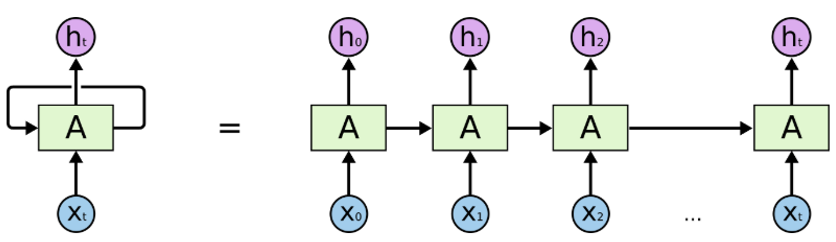

<u>Schema of a Bidirectional RNN layer :</u>

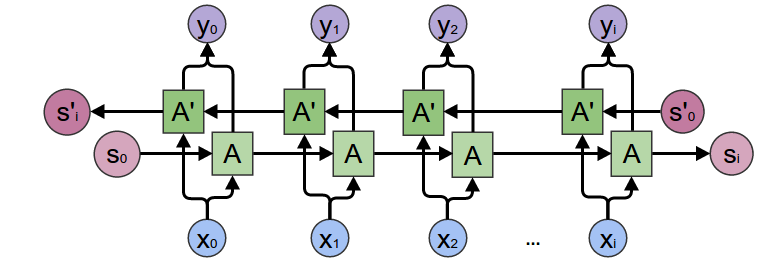

* <b>LSTM vs RNN?</b><br>
It appears that RNNs have a strong theorical limit called "Vanishing gradient". It can be shown that for long series, RNN models can't be well optimized. LSTM layers have been developed to address this issue. for more details on the vanishing gradient problem and how it has been addressed, please look at this paper: https://medium.com/datadriveninvestor/how-do-lstm-networks-solve-the-problem-of-vanishing-gradients-a6784971a577


<b>a_ training of the RNN</b>

In [80]:
def create_RNN_model():
    RNN = Sequential()
    RNN.add(Embedding(len(word_index) + 1, word_dimension, weights=[embedding_matrix], input_length = maxlen, trainable=False))

    RNN.add(Bidirectional(LSTM(word_dimension)))
    RNN.add(Dense(word_dimension, activation='relu'))
    RNN.add(Dense(1, activation='sigmoid'))
    RNN.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
    
    return RNN

In [81]:
RNN_model = create_RNN_model()

In [82]:
RNN_history = RNN_model.fit(feature_train, y_train, epochs=10, batch_size=16, validation_data=(feature_test, y_test))

Epoch 1/10
24/24 [==============================] - 5s 96ms/step - loss: 0.6749 - accuracy: 0.5584 - val_loss: 0.6231 - val_accuracy: 0.7872
Epoch 2/10
24/24 [==============================] - 2s 66ms/step - loss: 0.5544 - accuracy: 0.8457 - val_loss: 0.4116 - val_accuracy: 0.8298
Epoch 3/10
24/24 [==============================] - 2s 64ms/step - loss: 0.3591 - accuracy: 0.8753 - val_loss: 0.2102 - val_accuracy: 0.9362
Epoch 4/10
24/24 [==============================] - 2s 63ms/step - loss: 0.2497 - accuracy: 0.9100 - val_loss: 0.1862 - val_accuracy: 0.9468
Epoch 5/10
24/24 [==============================] - 2s 71ms/step - loss: 0.1673 - accuracy: 0.9280 - val_loss: 0.3054 - val_accuracy: 0.8830
Epoch 6/10
24/24 [==============================] - 2s 65ms/step - loss: 0.2286 - accuracy: 0.9058 - val_loss: 0.2099 - val_accuracy: 0.9149
Epoch 7/10
24/24 [==============================] - 2s 66ms/step - loss: 0.1335 - accuracy: 0.9564 - val_loss: 0.1460 - val_accuracy: 0.9149
Epoch 8/10
24


Some visualizations of the training :


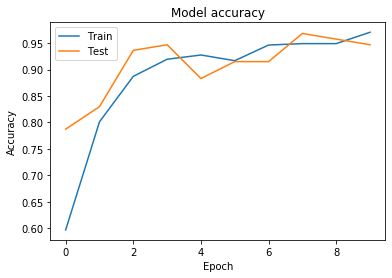

In [83]:
# Plot training & validation accuracy values
plt.plot(RNN_history.history['accuracy'])
plt.plot(RNN_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

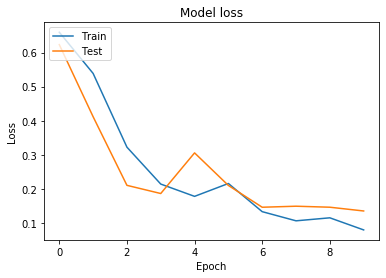

In [84]:
# Plot training & validation loss values
plt.plot(RNN_history.history['loss'])
plt.plot(RNN_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

<b>b_ Evaluation</b>

In [86]:
y_pred_RNN = RNN_model.predict(feature_test)

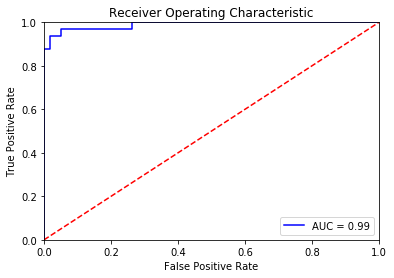

In [87]:
fpr, tpr, threshold = roc_curve(y_test, y_pred_RNN)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Conclusion

This Notebooks propose an implementation of some of the most famous algorithms used in NLP. NLP is vast and is growing very fast, I discuss below some other important models.

There is a great diversity of pre-built nlp tools such as Parsing models and linguistic models. You can find a great variety of open source software and libraries that propose such models.</br>
The following link gives a list of such opensource tools :</br>
https://opensource.com/article/19/3/natural-language-processing-tools
</br></br>

Moreover, NLP is in constant evolution. The Bert model, for instance, has been developed in late 2018 and gives spatial word representation that contains much more contextual information than the ones outputted by the skip-gram model. Recent papers show that Bert allows to out-perform the previous word2vec approaches in text classification. To learn more about the Bert model I invite you to follow the link below.
https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270
